In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display, Latex
from time import time
from sklearn.linear_model import RidgeCV, LassoCV
import statsmodels.api as sm
import pandas as pd

In [5]:
def stock_simu(S, T, r, sigma, N, M, seed):
    dt = T / N
    np.random.seed(seed)  
    paths = np.zeros((N + 1, M))
    paths[0] = S

    for t in range(1, N + 1):
        Z = np.random.standard_normal(int(M/2))
        Z = np.concatenate((Z, -Z))
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def least_squares_MC_ols(S, K, T, r, sigma, M, N, order = 5, option='put', seed=123): # M 表示步數，N代表共有幾條PATH
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N)) # discount factor
    stock_paths = stock_simu(S, T, r, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0
        reg = np.polyfit(stock_paths[t][in_the_money], exercise_values[t+1][in_the_money]*df, order)
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5, least_squares_MC_ols.__name__

def least_squares_MC_lasso(S, K, T, r, sigma, M, N, option='put', seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N)) # discount factor
    stock_paths = stock_simu(S, T, r, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0

        lasso_model = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)  # 設定 Lasso 模型的 alpha 參數
        X_train = stock_paths[t][in_the_money].reshape(-1, 1)  # 將數據轉換為列向量
        y_train = exercise_values[t+1][in_the_money]*df
        lasso_model.fit(X_train, y_train)  # 訓練 Lasso 模型
        reg = [lasso_model.intercept_, lasso_model.coef_[0]] 
        #print(f"The best alpha value for lasso is: {lasso_model.alpha_}")
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5, least_squares_MC_lasso.__name__

def least_squares_MC_ridge(S, K, T, r, sigma, M, N, option='put', seed=123): 
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N)) # discount factor
    stock_paths = stock_simu(S, T, r, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t]>=0

        ridge_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=5)  # 設定 Lasso 模型的 alpha 參數
        X_train = stock_paths[t][in_the_money].reshape(-1, 1)  # 將數據轉換為列向量
        y_train = exercise_values[t+1][in_the_money]*df
        ridge_model.fit(X_train, y_train)  # 訓練 Lasso 模型
        reg = [ridge_model.intercept_, ridge_model.coef_[0]] 
        #print(f"The best alpha value for ridge is: {ridge_model.alpha_}")
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df
    return np.mean(exercise_values[1]*df), np.std(exercise_values[1]*df)/M**0.5, least_squares_MC_ridge.__name__

def least_squares_MC_wls(S, K, T, r, sigma, M, N, option='put', seed=123):
    payoff = {'call': call, 'put': put}[option]
    df = np.exp(-r*(T/N)) # discount factor
    stock_paths = stock_simu(S, T, r, sigma, N, M, seed)

    payoffs = payoff(stock_paths, K)

    exercise_values = np.zeros_like(payoffs)
    exercise_values[-1] = payoffs[-1]

    for t in range(N-1, 0, -1):
        in_the_money = payoffs[t] >= 0
        #print(stock_paths[t][in_the_money])
        # 替換原本的 polyfit 部分
        X_train = sm.add_constant(stock_paths[t][in_the_money])  # 添加截距項
        y_train = exercise_values[t+1][in_the_money] * df
        weights = 1 / np.arange(1, len(y_train) + 1)  # 這裡使用了一個簡單的權重，你可以根據需要調整

        wls_model = sm.WLS(y_train, X_train, weights=weights)
        results = wls_model.fit()
        
        reg = results.params 
        C = np.polyval(reg, stock_paths[t][in_the_money])
        exercise_values[t][in_the_money] = np.where(payoffs[t][in_the_money] > C,
                                                    payoffs[t][in_the_money],
                                                    exercise_values[t+1][in_the_money] * df
                                                    )
        exercise_values[t][~in_the_money] = payoffs[t+1][~in_the_money] * df

    return np.mean(exercise_values[1] * df), np.std(exercise_values[1] * df) / M**0.5, least_squares_MC_wls.__name__





Pricing Value by ols
-----------------
Monte Carlo mean: 2.273
Monte Carlo std: 0.012
Pricing Value by lasso
-----------------
Monte Carlo mean: 2.072
Monte Carlo std: 0.015
Pricing Value by ridge
-----------------
Monte Carlo mean: 2.072
Monte Carlo std: 0.015
Pricing Value by wls
-----------------
Monte Carlo mean: 2.072
Monte Carlo std: 0.015


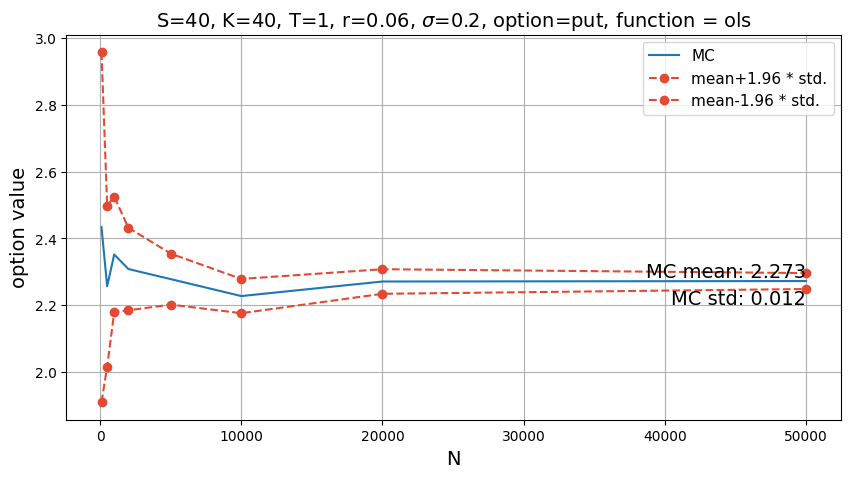

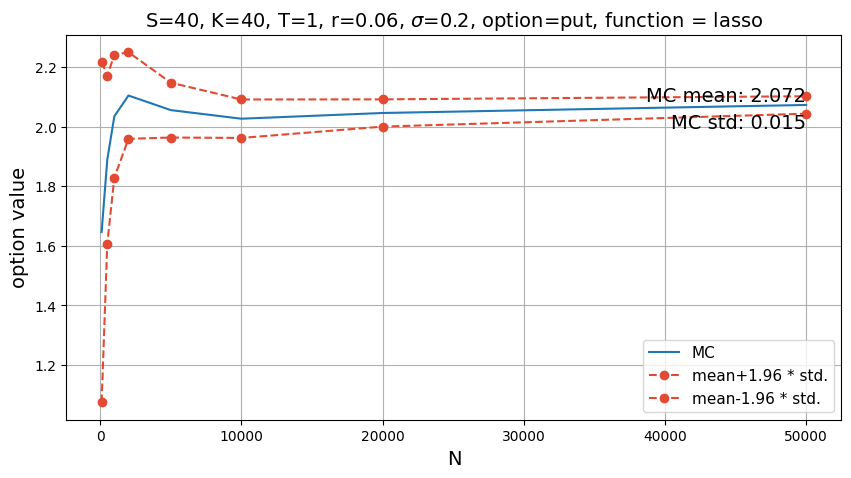

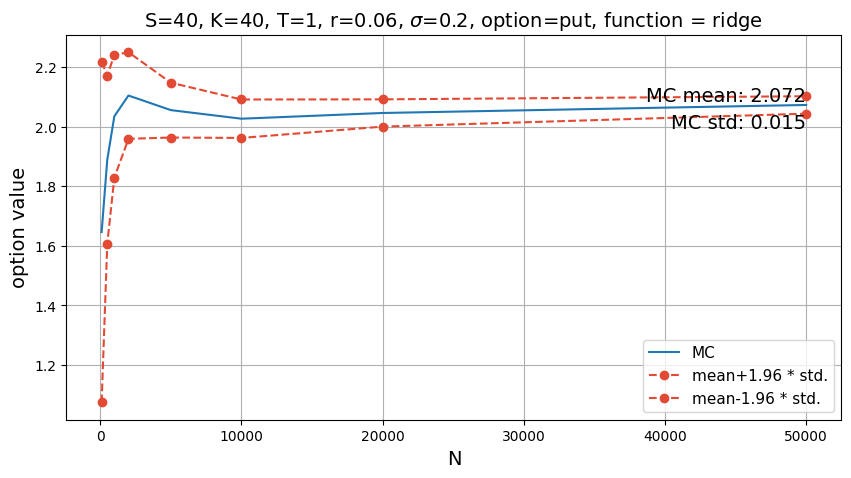

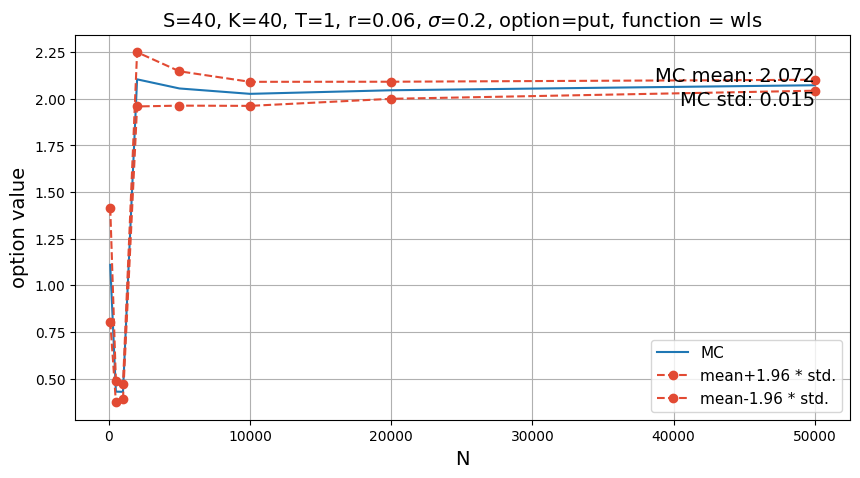

In [6]:
funcs = [least_squares_MC_ols, least_squares_MC_lasso, least_squares_MC_ridge, least_squares_MC_wls]
S = 40
K = 40
T = 1
r = 0.06
sigma = 0.2
N = 50
option = 'put'
M = [100, 500, 1000, 2000, 5000, 10000, 20000, 50000]
# stock_paths = stock_simu(S, T, r, sigma, N, M, 225)
for func in funcs: 
    mc_mean = []
    mc_std = []
    for n in M:
        m, s, name = func(S, K, T, r, sigma, n, N)
        mc_mean.append(m)
        mc_std.append(s)

    mc_mean = np.array(mc_mean)
    mc_std = np.array(mc_std)

    analysis_N = M
    name = name.split('_')[3]
    print('=================')
    print(f'Pricing Value by {name}')
    print('-----------------')
    print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
    print(f'Monte Carlo std: {mc_std[-1]:.3f}')

    plt.figure(figsize=(10,5))
    plt.plot(M, mc_mean, label='MC')
    plt.plot(M, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
    plt.plot(M, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')
    plt.grid()
    plt.text(M[-1], mc_mean[-1], f'MC mean: {mc_mean[-1]:.3f}', verticalalignment='bottom', horizontalalignment='right', fontsize=14)
    plt.text(M[-1], mc_mean[-1]-1.96*mc_std[-1], f'MC std: {mc_std[-1]:.3f}', verticalalignment='top', horizontalalignment='right', fontsize=14)

    plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}, function = {name}', fontsize=14)
    plt.xlabel('N', fontsize=14)
    plt.ylabel('option value', fontsize=14)
    plt.legend(loc = 'best', fontsize=11)

### Compare with CRR

In [7]:
paths = np.arange(100, 10001, 300)

In [8]:
def binomial_tree(S, K, T, r, sigma, N, method, option, Astyle=None): # N代表步數
    dt = T/N # time increament
    df = np.exp(-r*dt) # discount factor

    payoff = {'call': call, 'put': put}[option]
    
    # u, q, d 的計算方式不同
    if method == 'CRR':
        u = np.exp(sigma*np.sqrt(dt))
        d = 1/u
        q = (np.exp(r*dt)-d) / (u-d)
    elif method == 'JR':
        u = np.exp((r-0.5*sigma**2)*dt + sigma*dt**0.5)
        d = np.exp((r-0.5*sigma**2)*dt - sigma*dt**0.5)
        q = 0.5

    stock_path = np.zeros((N+1, N+1))
    stock_path[0,0] = S
    for i in range(1, N+1):
        for j in range(i+1):
            stock_path[i,j] = S * u**(i-j) * d**j

    option_value = np.maximum(payoff(stock_path[N], K), 0)
    for i in range(N, 0, -1):
        for j in range(i):
            option_value[j] = (q * option_value[j] + (1-q) * option_value[j+1]) * df
            if Astyle == True:
                option_value[j] = max(option_value[j], payoff(stock_path[i-1, j], K))
    return option_value[0]

In [16]:
S = 40
K = 40
T = 1
r = 0.06
sigma = 0.2
option = 'put'
N = paths
crr_res = []
jr_res = []
crr_time = []
jr_time = []
for n in N:
    t1 = time()
    crr = (binomial_tree(S, K, T, r, sigma, n, 'CRR', option, True))
    t2 = time()
    crr_res.append(crr)
    crr_time.append(t2-t1)

    t1 = time()
    jr = (binomial_tree(S, K, T, r, sigma, n, 'JR', option, True))
    t2 = time()
    jr_res.append(jr)
    jr_time.append(t2-t1)

M = paths # path代表中間的步數
N = 50 #幾條path
mc_mean = []
mc_std = []
mc_time = []
for n in M: 
    '''這邊代表用的步數，與各自對應的標準差與平均值，以及花費的時間'''
    t1 = time()
    m, s, _ = least_squares_MC_lasso(S, K, T, r, sigma, n, N, option) # n表示步數，N代表幾條PATH
    t2 = time()
    mc_time.append(t2-t1)
    mc_mean.append(m)
    mc_std.append(s)

In [ ]:
bin_res = pd.DataFrame({
    'N': paths,
    'CRR': crr_res,
    'CRR time': crr_time,
    'JR': jr_res,
    'JR time': jr_time,
})

lsmc_res = pd.DataFrame({
    'N': paths,
    'LSMC': mc_mean,
    'LSMC time': mc_time
})

print('Binomial Tree')
print(bin_res.T)
print('============================================================================')
print('Least Square Monte Carlo')
print(lsmc_res.T)

Binomial Tree
                  0           1           2            3            4   \
N         100.000000  400.000000  700.000000  1000.000000  1300.000000   
CRR         4.387777    4.393807    4.394669     4.395014     4.395200   
CRR time    0.012998    0.190505    0.584405     1.177871     2.308296   
JR          4.388331    4.393946    4.396678     4.395867     4.396327   
JR time     0.013076    0.195165    0.595354     1.194740     2.622907   

                   5            6            7            8            9   \
N         1600.000000  1900.000000  2200.000000  2500.000000  2800.000000   
CRR          4.395316     4.395396     4.395454     4.395498     4.395532   
CRR time     3.801416     4.187284     5.794812     7.500149     9.123707   
JR           4.395351     4.396138     4.396052     4.395520     4.395986   
JR time      3.073624     4.226840     5.793907     7.316916     9.023220   

          ...           24           25           26           27  \
N        

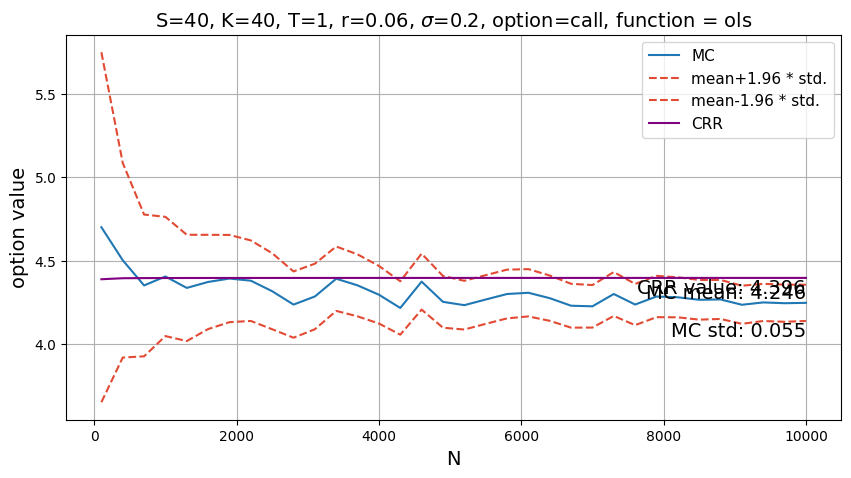

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(M, mc_mean, label='MC')
plt.plot(M, mc_mean + 1.96 * np.array(mc_std), label='mean+1.96 * std.', color='#E24A33', linestyle='--')
plt.plot(M, mc_mean - 1.96 * np.array(mc_std), label='mean-1.96 * std.', color='#E24A33',  linestyle='--')
plt.plot(M, crr_res, label='CRR', color ='purple')
plt.grid()
plt.text(M[-1], mc_mean[-1], f'MC mean: {mc_mean[-1]:.3f}', verticalalignment='bottom', horizontalalignment='right', fontsize=14)
plt.text(M[-1], mc_mean[-1]-1.96*mc_std[-1], f'MC std: {mc_std[-1]:.3f}', verticalalignment='top', horizontalalignment='right', fontsize=14)
plt.text(M[-1], crr_res[-1], f'CRR value: {crr_res[-1]:.3f}', verticalalignment='top', horizontalalignment='right', fontsize=14)

plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}, function = ols', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(loc = 'best', fontsize=11)